# EDA + base models

## Load modules

In [3]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

In [4]:
df = pd.read_csv('data/imdb/IMDB Dataset.csv')

In [5]:
df.shape

(50000, 2)

#### Taking only a small portion of the data to do EDA

In [6]:
df = df.sample(n=5000).reset_index(drop=True)

In [7]:
# This is what it looks like
df.head()

,review,sentiment
0,"The film notes describe the main role family, ...",positive
1,The Ali G character works brilliantly within t...,positive
2,There were a lot of things going against this ...,positive
3,"i was part of the cast of Space Odyssey, playi...",positive
4,Shakespeare Behind Bars was a strangely uplift...,positive


#### No nulls found

In [6]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     5000 non-null   object
 1   sentiment  5000 non-null   object
dtypes: object(2)
memory usage: 78.2+ KB


#### Some utility functions to clean the data and parallelize it

In [8]:
from bs4 import BeautifulSoup
import multiprocess as mp
import numpy as np
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

def clean_html(text):
    if text.strip():
        return BeautifulSoup(text, "lxml").text
    else:
        return ''


def lemmatize(text):
    doc = nlp(text)
    lemmatized_list =  [token.lemma_ for token in doc]
    return ' '.join(lemmatized_list)


def parallelize(series, func, cores=None):
    if not cores:
        cores = mp.cpu_count()-1
    series_split = np.array_split(series, cores)
    pool = mp.Pool(cores)
    modified_series = pd.concat(pool.map(lambda x: x.apply(func), series_split))
    pool.close()
    pool.join()
    return modified_series


In [9]:
%timeit df['review'] = parallelize(df['review'], clean_html)

219 ms ± 4.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%timeit df['review'] = parallelize(df['review'], lemmatize)

39.5 s ± 970 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Almost equal distribution of data

<AxesSubplot:xlabel='sentiment', ylabel='count'>

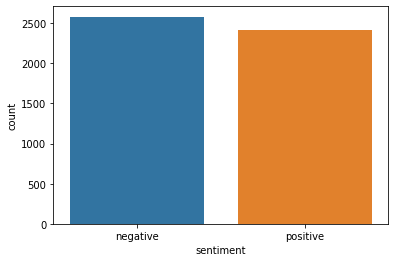

In [11]:
sns.countplot(data=df, x='sentiment')

In [12]:
def string_len(text):
    return len(text)


def words_in_sentence(text):
    return len(text.split())

In [13]:
%timeit df['total_length'] = parallelize(df['review'], string_len)

80.8 ms ± 260 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%timeit df['words_in_sentence'] = parallelize(df['review'], words_in_sentence)

90.9 ms ± 481 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Distribution of lengths

<AxesSubplot:xlabel='words_in_sentence', ylabel='Count'>

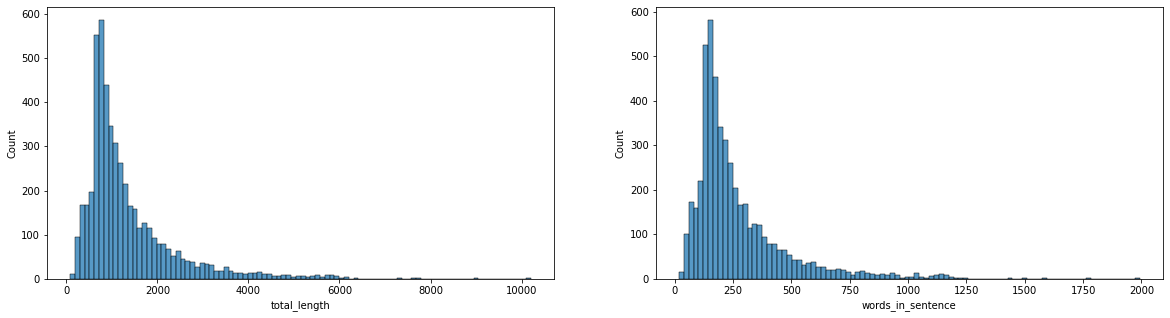

In [15]:
figs, ax = plt.subplots(1,2, figsize=(20,5))
ax = ax.flatten()
sns.histplot(data=df, x='total_length', ax=ax[0])
sns.histplot(data=df, x='words_in_sentence', ax=ax[1])

### Distribution of lengths wrt class

<AxesSubplot:xlabel='words_in_sentence', ylabel='Count'>

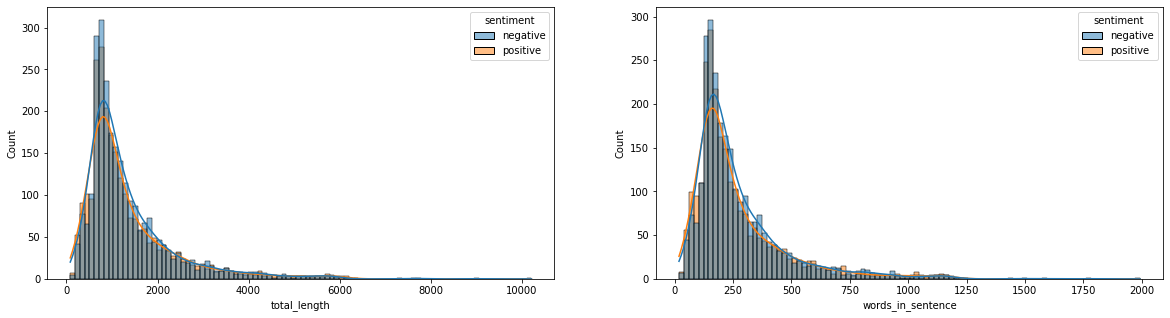

In [16]:
figs, ax = plt.subplots(1,2, figsize=(20,5))
ax = ax.flatten()
sns.histplot(data=df, x='total_length', hue='sentiment', ax=ax[0], kde=1)
sns.histplot(data=df, x='words_in_sentence', hue='sentiment', ax=ax[1], kde=1)

### Box plot of distribution of lengths wrt class (clearer picture)

<AxesSubplot:xlabel='sentiment', ylabel='words_in_sentence'>

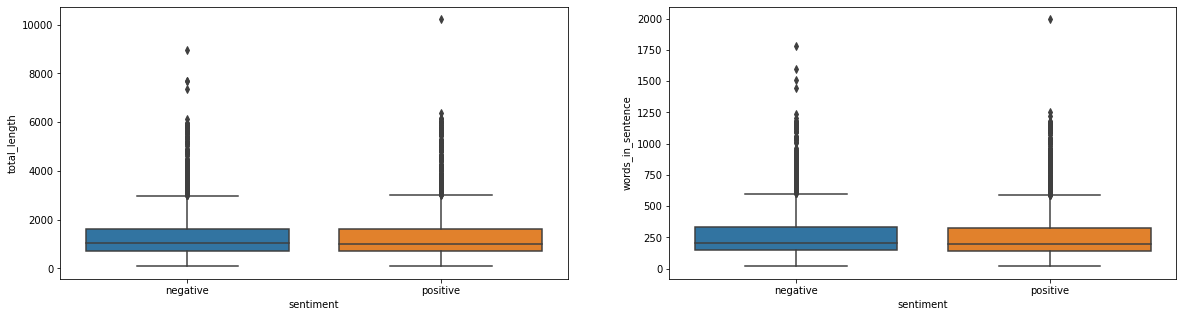

In [17]:
figs, ax = plt.subplots(1,2, figsize=(20,5))
ax = ax.flatten()
sns.boxplot(data=df, y='total_length', x='sentiment', ax=ax[0])
sns.boxplot(data=df, y='words_in_sentence', x='sentiment', ax=ax[1])

#### I had really hoped that there would be some information in the lengths of review. I had a hunch that negative reviews would be longer. Unfortunately that is not the case

In [18]:
print(df['review'].values[3])

-PRON- seem ever since 1982 , about every two or three year -PRON- get a movie that claim to be " the Next Officer and a Gentleman . " there have yet to be one movie that have live up to this claim and this movie be no different . -PRON- get the usual rip off scene from OAAG ( " -pron- want -PRON- DOR , " the instructor give the Richard Gere character -PRON- overdose of drill in hope -PRON- will quit , the Gere character come back for the girl , the Gere character realize the instructor be great , etc . ) and this movie be as predictable as the sun rise in the East and be horribly miscast on top . costner play -pron- usual " wise teacher " character , the only character -PRON- can play , and -PRON- really get a sense of -PRON- limit act ability here . Kutcher be terrible in the Richard Gere character , just miscast with act skill barely a notch above Keanu Reeves . the main problem with this OAAG wannabe be the two main character be so amazingly one - dimensional , -PRON- never care fo

In [19]:
df['words_in_sentence'].describe()

count    5000.000000
mean      269.680200
std       200.968644
min        18.000000
25%       146.000000
50%       203.000000
75%       326.250000
max      1994.000000
Name: words_in_sentence, dtype: float64

#### Eliminating some really long reviews because we don't want them in our models. We would treat them to be outliers

In [20]:
threshold = np.percentile(df['words_in_sentence'], 95)

df = df[df['words_in_sentence'] <= threshold]

In [21]:
df.shape

(4750, 4)

In [22]:
from collections import Counter
words = []
for i in df['review']:
    words.extend(i.split())
uniques = Counter(words)
del words

### Occurence plot of words

<AxesSubplot:>

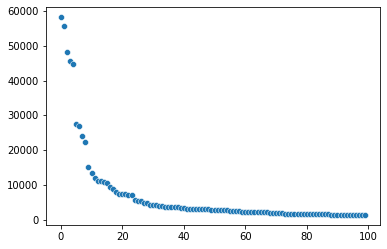

In [23]:
sns.scatterplot(x=range(len(uniques))[:100], y=sorted(uniques.values(), reverse=True)[:100])

### Model building

In [39]:

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler


#### Train test split

In [27]:
train_df, test_df = train_test_split(df, test_size=0.20, random_state=42, stratify=df['sentiment'])

### Defining model functions

In [82]:
def logistic_regression(X_train, X_test):
    lr = LogisticRegression(solver='liblinear')
    params = {'penalty': ['l1', 'l2'],
            'C':[1e-2, 1e-1, 1, 1e1, 1e2],
             'max_iter': [100, 200, 500, 1000]}
    clf = GridSearchCV(lr, params, n_jobs=-1, cv=3, verbose=0)
    clf.fit(X_train, X_test)
    return clf


def naive_bayes_mnb(X_train, X_test):
    nb = MultinomialNB()
    params = {'alpha': [1e-2, 1e-1, 1, 1e2, 1e3]}
    clf = GridSearchCV(nb, params, n_jobs=-1, cv=3, verbose=0)
    clf.fit(X_train, X_test)
    return clf


def random_forest(X_train, X_test):
    rf = RandomForestClassifier(n_jobs=-1)
    params = {'n_estimators': [50, 100, 150, 200],
             'max_depth': [None, 5, 10, 15, 20]}
    clf = GridSearchCV(rf, params, n_jobs=-1, cv=3, verbose=0)
    clf.fit(X_train, X_test)
    return clf


def gradient_boosted_tree(X_train, X_test):
    gbdt = GradientBoostingClassifier()
    params = {'learning_rate': [1e-3, 1e-2, 1e-1, 1],
             'n_estimators': [20, 50, 100, 150, 200],
             'max_depth': [1, 2, 3]}
    clf = GridSearchCV(gbdt, params, n_jobs=-1, cv=3, verbose=0)
    clf.fit(X_train, X_test)
    return clf

#### Util functions

In [67]:
# Removing stopwords

from spacy.lang.en.stop_words import STOP_WORDS
import re

def remove_stopwords(text):
    for s in STOP_WORDS:
        text = text.replace(s, '')
    return re.sub('\s+', ' ', text)

# metric
from sklearn.metrics import classification_report

def report(X_test, y_test, classifier):
    y_pred = classifier.predict(X_test)
    repor = classification_report(y_test, y_pred)
    print(repor)

### Featurizing - BOW

In [68]:
# Bag of Words

bow = CountVectorizer()
X_train = bow.fit_transform(train_df['review'].progress_apply(remove_stopwords))
X_test = bow.transform(test_df['review'].progress_apply(remove_stopwords))

# s = StandardScaler()
# X_train = s.fit_transform(X_train)
# X_test = s.transform(X_test)

y_train = train_df['sentiment'].values
y_test = test_df['sentiment'].values

100%|██████████| 950/950 [00:00<00:00, 2729.25it/s]


In [69]:
X_train.shape

(3800, 20131)

In [70]:
lr = logistic_regression(X_train, y_train)

In [71]:
report(X_test, y_test, lr)

              precision    recall  f1-score   support

    negative       0.86      0.82      0.84       491
    positive       0.82      0.86      0.84       459

    accuracy                           0.84       950
   macro avg       0.84      0.84      0.84       950
weighted avg       0.84      0.84      0.84       950



In [74]:
nb = naive_bayes_mnb(X_train, y_train)
print('Done!')

Done!


In [75]:
report(X_test, y_test, nb)

              precision    recall  f1-score   support

    negative       0.81      0.82      0.82       491
    positive       0.81      0.79      0.80       459

    accuracy                           0.81       950
   macro avg       0.81      0.81      0.81       950
weighted avg       0.81      0.81      0.81       950



In [79]:
rf = random_forest(X_train, y_train)
print('Done!')

Done!


In [80]:
report(X_test, y_test, rf)

              precision    recall  f1-score   support

    negative       0.80      0.84      0.82       491
    positive       0.82      0.78      0.80       459

    accuracy                           0.81       950
   macro avg       0.81      0.81      0.81       950
weighted avg       0.81      0.81      0.81       950



In [83]:
gbdt = gradient_boosted_tree(X_train, y_train)
print('Done!')

Done!


In [84]:
report(X_test, y_test, gbdt)

              precision    recall  f1-score   support

    negative       0.83      0.79      0.81       491
    positive       0.79      0.83      0.81       459

    accuracy                           0.81       950
   macro avg       0.81      0.81      0.81       950
weighted avg       0.81      0.81      0.81       950



In [120]:
def probabilty_distribution_graph(X_test, y_test, classifer, ax=None):
    probs = classifer.predict_proba(X_test)
    prob = probs[:, 1]
    prob_df = pd.DataFrame({'real': y_test, 'probs': prob})
    sns.histplot(data=prob_df, x='probs', hue='real', kde=True, ax=ax)
    if ax:
        ax.set_title(str(classifer.best_estimator_.__class__))

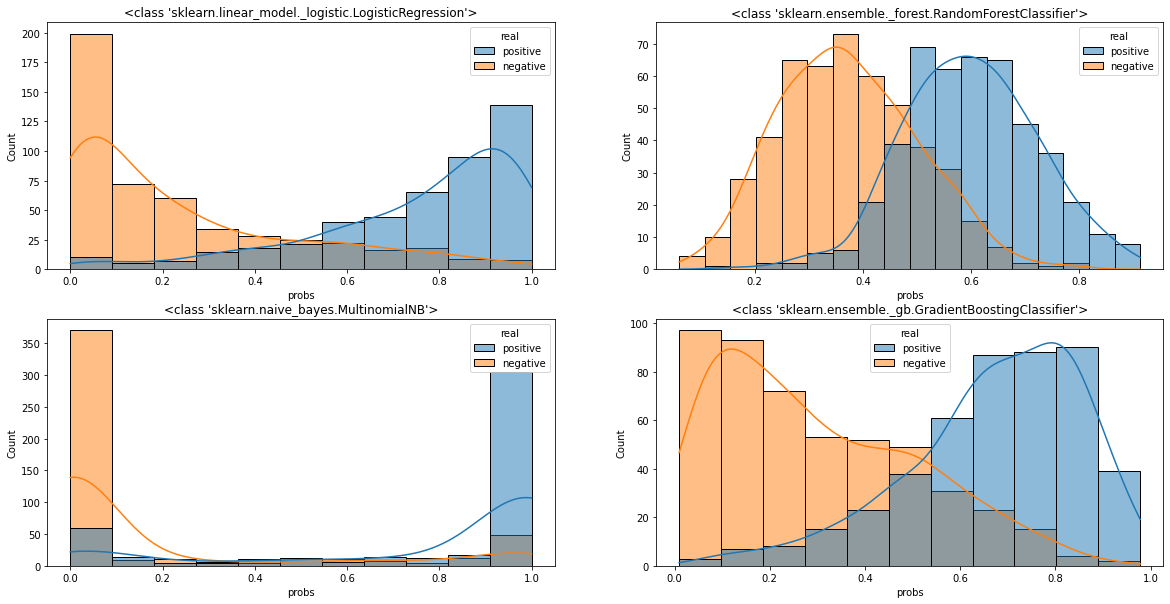

In [121]:
fig, ax = plt.subplots(2,2, figsize=(20,10))
ax = ax.flatten()

probabilty_distribution_graph(X_test, y_test, lr, ax[0])
probabilty_distribution_graph(X_test, y_test, rf, ax[1])
probabilty_distribution_graph(X_test, y_test, nb, ax[2])
probabilty_distribution_graph(X_test, y_test, gbdt, ax[3])

### Logistic regression and Naive Bayes graph looks the best

#### Some more util functions

In [126]:
def model_fitter(X_train, y_train):
    lr = logistic_regression(X_train, y_train)
    mnb = naive_bayes_mnb(X_train, y_train)
    rf = random_forest(X_train, y_train)
    gbdt = gradient_boosted_tree(X_train, y_train)
    return lr, mnb, rf, gbdt

def reporter(X_test, y_test, classifiers):
    for c in classifiers:
        print('Model: %s' % c.best_estimator_.__class__)
        report(X_test, y_test, c)

### Featurizing - tfidf

In [122]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_vec = TfidfVectorizer()
X_train = tfidf_vec.fit_transform(train_df['review'].progress_apply(remove_stopwords))
X_test = tfidf_vec.transform(test_df['review'].progress_apply(remove_stopwords))


y_train = train_df['sentiment'].values
y_test = test_df['sentiment'].values

100%|██████████| 950/950 [00:00<00:00, 2734.96it/s]


In [128]:
X_train.shape

(3800, 20131)

In [124]:
models = model_fitter(X_train, y_train)

In [127]:
reporter(X_test, y_test, models)

Model: <class 'sklearn.linear_model._logistic.LogisticRegression'>
              precision    recall  f1-score   support

    negative       0.87      0.83      0.85       491
    positive       0.82      0.87      0.85       459

    accuracy                           0.85       950
   macro avg       0.85      0.85      0.85       950
weighted avg       0.85      0.85      0.85       950

Model: <class 'sklearn.naive_bayes.MultinomialNB'>
              precision    recall  f1-score   support

    negative       0.80      0.81      0.80       491
    positive       0.79      0.79      0.79       459

    accuracy                           0.80       950
   macro avg       0.80      0.80      0.80       950
weighted avg       0.80      0.80      0.80       950

Model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
              precision    recall  f1-score   support

    negative       0.79      0.84      0.82       491
    positive       0.82      0.76      0.79       459


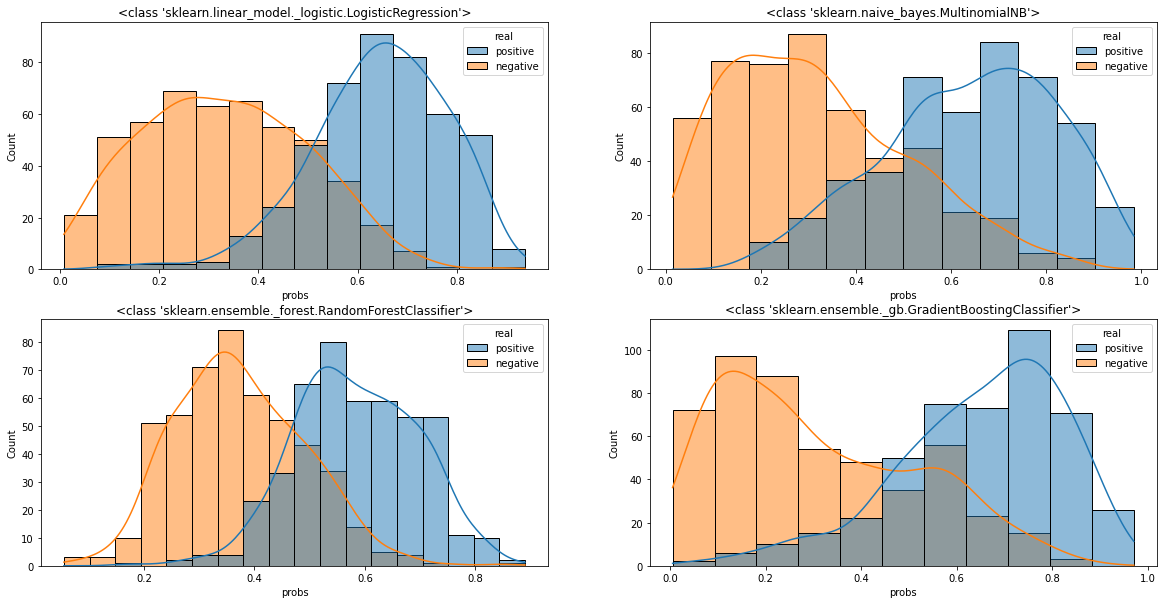

In [129]:
fig, ax = plt.subplots(2,2, figsize=(20,10))
ax = ax.flatten()

probabilty_distribution_graph(X_test, y_test, models[0], ax[0])
probabilty_distribution_graph(X_test, y_test, models[1], ax[1])
probabilty_distribution_graph(X_test, y_test, models[2], ax[2])
probabilty_distribution_graph(X_test, y_test, models[3], ax[3])

### Modified tfidf

In [130]:
modified_tfidf = TfidfVectorizer(max_df=0.9, max_features=500)

X_train = modified_tfidf.fit_transform(train_df['review'])
X_test = modified_tfidf.transform(test_df['review'])

y_train = train_df['sentiment'].values
y_test = test_df['sentiment'].values

In [131]:
X_train.shape

(3800, 500)

In [132]:
models = model_fitter(X_train, y_train)

In [133]:
reporter(X_test, y_test, models)

Model: <class 'sklearn.linear_model._logistic.LogisticRegression'>
              precision    recall  f1-score   support

    negative       0.85      0.85      0.85       491
    positive       0.84      0.84      0.84       459

    accuracy                           0.84       950
   macro avg       0.84      0.84      0.84       950
weighted avg       0.84      0.84      0.84       950

Model: <class 'sklearn.naive_bayes.MultinomialNB'>
              precision    recall  f1-score   support

    negative       0.80      0.84      0.82       491
    positive       0.82      0.78      0.80       459

    accuracy                           0.81       950
   macro avg       0.81      0.81      0.81       950
weighted avg       0.81      0.81      0.81       950

Model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
              precision    recall  f1-score   support

    negative       0.83      0.80      0.81       491
    positive       0.79      0.82      0.81       459


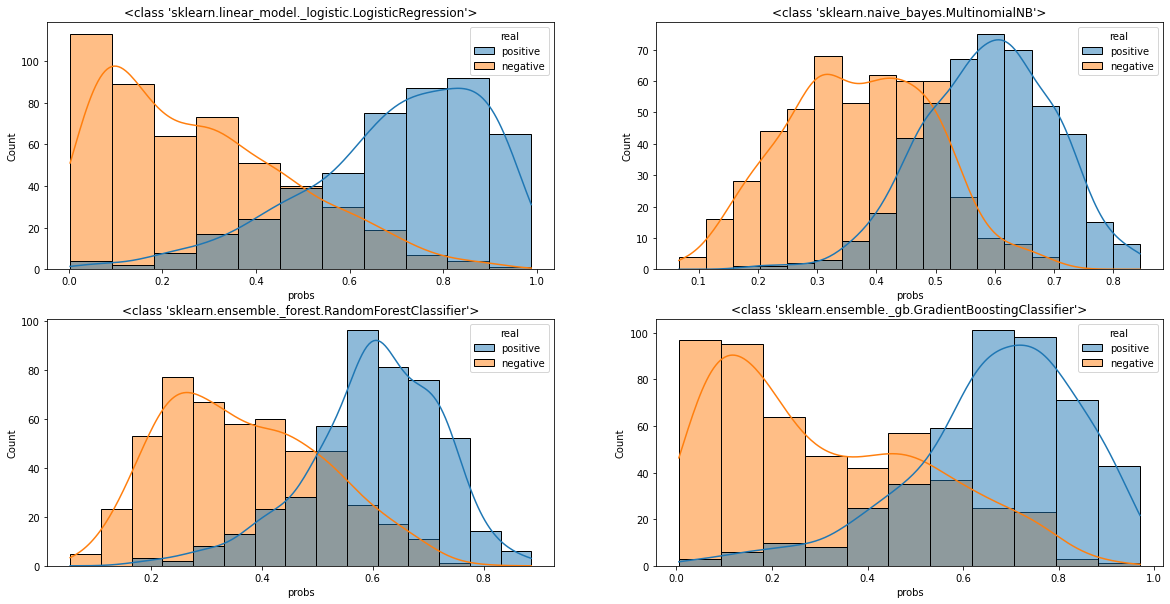

In [134]:
fig, ax = plt.subplots(2,2, figsize=(20,10))
ax = ax.flatten()

probabilty_distribution_graph(X_test, y_test, models[0], ax[0])
probabilty_distribution_graph(X_test, y_test, models[1], ax[1])
probabilty_distribution_graph(X_test, y_test, models[2], ax[2])
probabilty_distribution_graph(X_test, y_test, models[3], ax[3])

### When we take just 100 features the performance decreases

In [135]:
modified_tfidf_2 = TfidfVectorizer(max_df=0.9, max_features=100)

X_train = modified_tfidf_2.fit_transform(train_df['review'])
X_test = modified_tfidf_2.transform(test_df['review'])

y_train = train_df['sentiment'].values
y_test = test_df['sentiment'].values

In [136]:
models = model_fitter(X_train, y_train)

reporter(X_test, y_test, models)

Model: <class 'sklearn.linear_model._logistic.LogisticRegression'>
              precision    recall  f1-score   support

    negative       0.77      0.75      0.76       491
    positive       0.74      0.75      0.75       459

    accuracy                           0.75       950
   macro avg       0.75      0.75      0.75       950
weighted avg       0.75      0.75      0.75       950

Model: <class 'sklearn.naive_bayes.MultinomialNB'>
              precision    recall  f1-score   support

    negative       0.71      0.80      0.75       491
    positive       0.75      0.66      0.70       459

    accuracy                           0.73       950
   macro avg       0.73      0.73      0.73       950
weighted avg       0.73      0.73      0.73       950

Model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
              precision    recall  f1-score   support

    negative       0.77      0.75      0.76       491
    positive       0.74      0.75      0.75       459


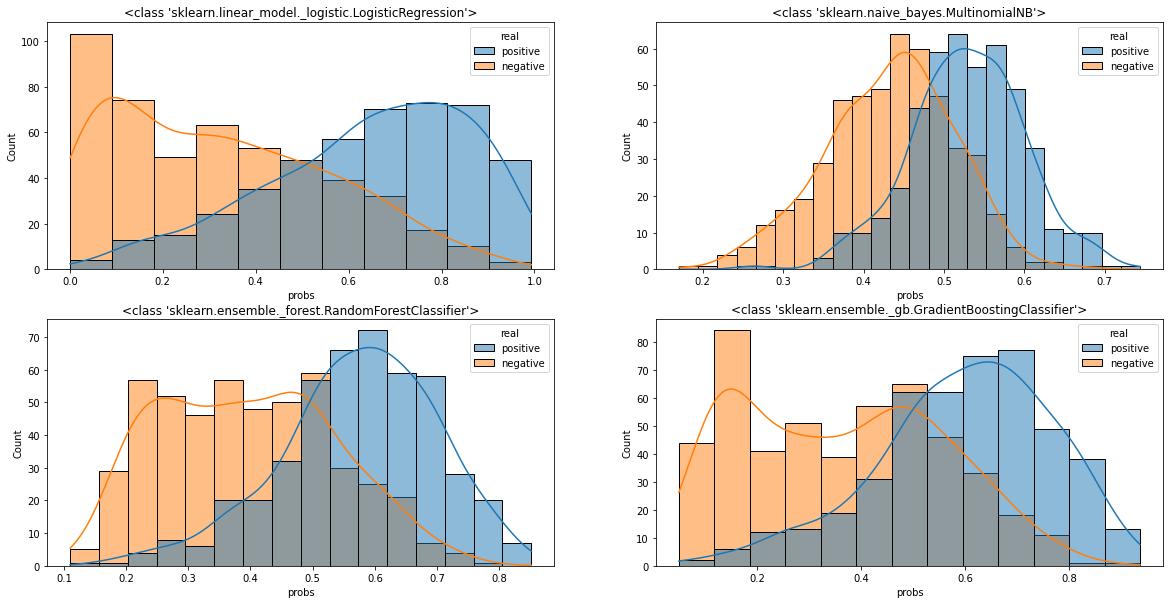

In [137]:
fig, ax = plt.subplots(2,2, figsize=(20,10))
ax = ax.flatten()

probabilty_distribution_graph(X_test, y_test, models[0], ax[0])
probabilty_distribution_graph(X_test, y_test, models[1], ax[1])
probabilty_distribution_graph(X_test, y_test, models[2], ax[2])
probabilty_distribution_graph(X_test, y_test, models[3], ax[3])

In [9]:
# some things to try

# word2vec

# tf-idf weighted w2v

# Analysis of misclassified points

# Train with the entire dataset